## Proximal Policy Optimization (PPO) for Constrained Lunar Landing


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Lunar_Lander/

/content/drive/MyDrive/Lunar_Lander


Installing the needed libraires

In [4]:
!apt-get install -y xvfb ffmpeg
!pip install pyvirtualdisplay
!pip install gymnasium[box2d]
!pip install stable-baselines3
!pip install moviepy
!pip install swig
!pip install "gymnasium[box2d]"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 30 not upgraded.
Need to get 7,817 kB of archives.
After this operation, 12.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main a

Importing the needed librairies

In [3]:
import gymnasium as gym
from pyvirtualdisplay import Display
from gymnasium.wrappers import RecordVideo
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle


## Q-learning Agent
We start with a Q-learning agent. We will show its weaknesses and the need to have the PPO agent.

In [10]:
from q_learning_train import q_learning_train

q_learning_train()
with open("q_table_best.pkl", "rb") as f:
    q_table = pickle.load(f)

print("Q-table chargée avec succès. Nombre d'états rencontrés :", len(q_table))


Training Q-Learning: 100%|██████████| 20000/20000 [05:38<00:00, 59.07it/s]


Q-table chargée avec succès. Nombre d'états rencontrés : 13496


Let's evaluate our agent.

100%|██████████| 500/500 [00:05<00:00, 83.63it/s]


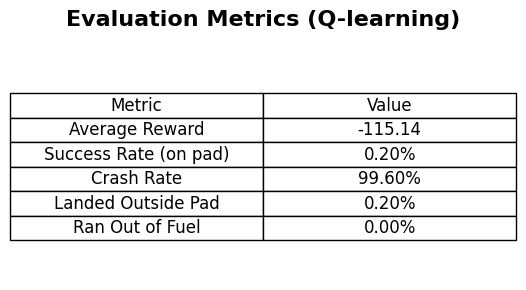

In [14]:
from evaluate_q_table import evaluate_q_table
evaluate_q_table()

We saw quickly that this architeture had poor results.

##Proximal Policy Optimization (PPO) Agent
Our hyperparameters are in config.py

We import the core components for PPO with Reward Shaping & Normalization, from the ppo_components.py file








This script (`train_ppo.py`) trains a PPO agent on the `CustomLunarLander-v0` environment. Here's a succinct overview of what the script does:

1. **Initialization**:
   - Initializes the actor-critic model, optimizer, and a running normalizer for state inputs.
   - Creates the environment and extracts the state and action dimensions.

2. **Rollout Collection**:
   - Collects a fixed number of interactions (rollouts) from the environment (e.g., 2048 steps).
   - Stores the states, actions, rewards, log probabilities, done flags, and value estimates in a rollout buffer.
   - Applies reward shaping (small penalties) based on specific conditions (e.g., vertical speed).

3. **Advantage and Return Calculation**:
   - Computes advantages using Generalized Advantage Estimation (GAE).
   - Calculates returns by adding the advantages to the corresponding value estimates.

4. **Model Update**:
   - Converts the collected data into tensors.
   - Splits the data into mini-batches and performs multiple epochs of updates.
   - Optimizes the PPO loss, which includes the policy loss (with clipping), value loss, and an entropy bonus for exploration.

5. **Logging and Saving**:
   - Logs training metrics such as average return, policy loss, value loss, entropy, KL divergence, and explained variance.
   - Saves the best model (based on average return) and the final model at the end of training.

This modular approach, along with the separation of core components into `ppo_components.py`, helps maintain clean and reusable code.


In [ ]:
!python train_ppo.py

Device: cpu
/content/drive/MyDrive/Lunar_Lander/train_ppo.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor(buffer.states).to(device)
Update 1, Average Reward: -178.24
Update 2, Average Reward: -185.67
Update 3, Average Reward: -150.89
Update 4, Average Reward: -170.76
Update 5, Average Reward: -171.29
Update 6, Average Reward: -179.57
Update 7, Average Reward: -151.13
Update 8, Average Reward: -144.99
Update 9, Average Reward: -132.79
Update 10, Average Reward: -136.17
Update 11, Average Reward: -146.91
Update 12, Average Reward: -142.88
Update 13, Average Reward: -176.77
Update 14, Average Reward: -170.11
Update 15, Average Reward: -208.65
Update 16, Average Reward: -153.96
Update 17, Average Reward: -167.44
Update 18, Average Reward: -1

This script loads the training metrics saved in `training_logs_.npz` (which include average return, policy loss, value loss, entropy, KL divergence, and explained variance). It then creates three subplots:

- **Learning Signal:** Plots the average return (scaled) and explained variance.
- **Losses:** Plots the policy loss and value loss.
- **Policy Behavior:** Plots the entropy and KL divergence.

Each plot uses twin y-axes to display two metrics on the same graph, with proper labels, titles, and legends to ensure clarity. At the end of the script, the plots are displayed using `plt.show()`.


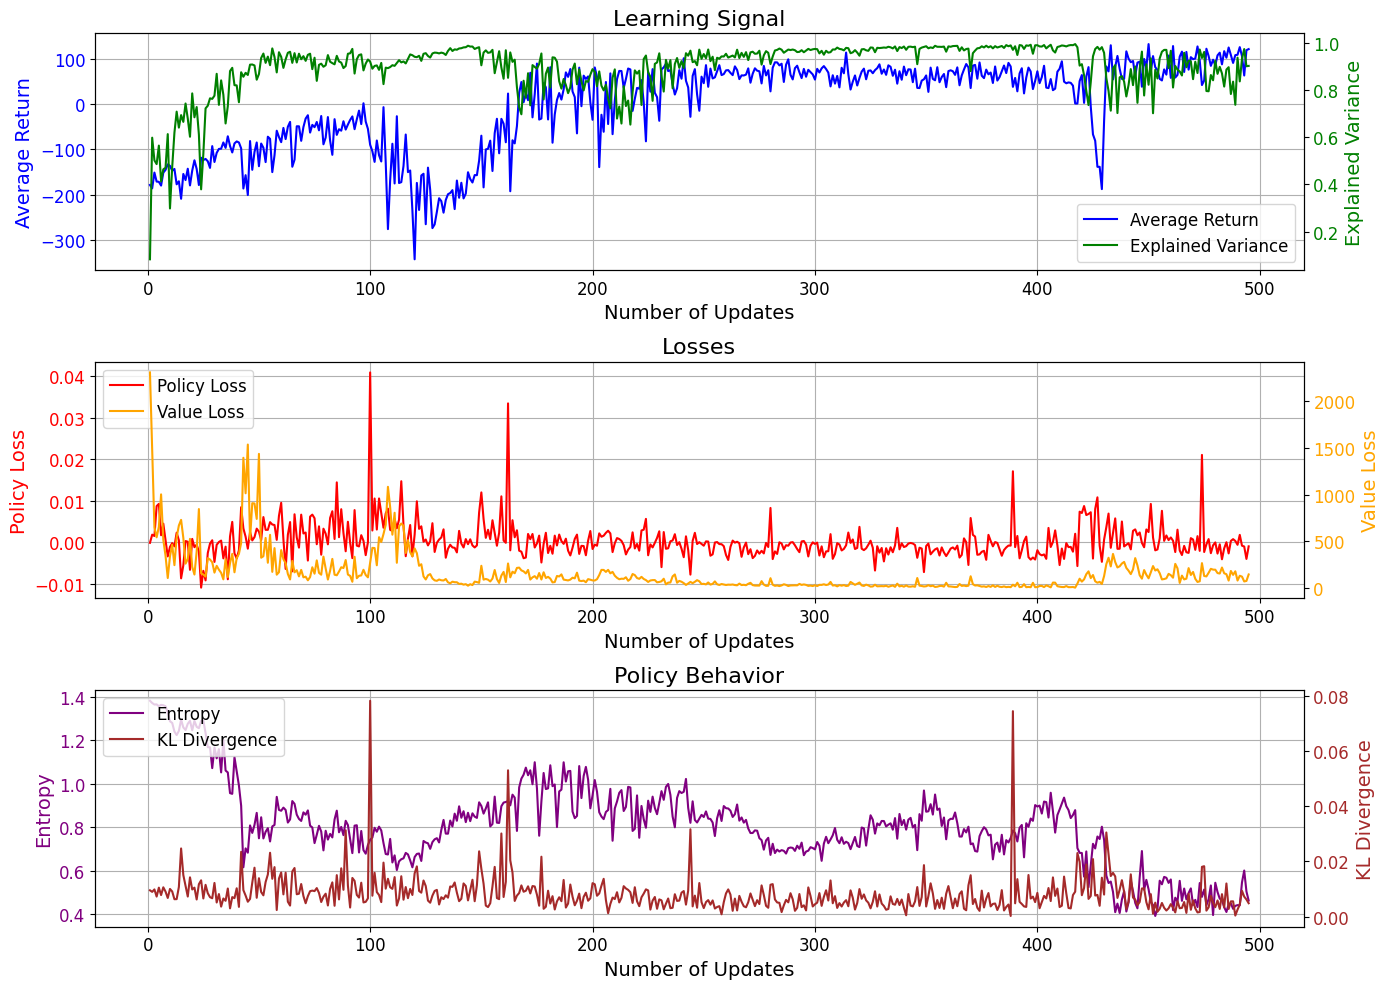

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
%run plot_training_logs.py

These plots show the evolution of key metrics during the training of a PPO agent.

- **Average Return (blue):**  
  Represents the mean reward accumulated over one or more episodes within each update cycle. As we can see, it is increasing on average during the 500 epochs. However, it has a non-negligible variance due to the exploration of the agent.

- **Explained Variance (green):**  
  Measures how well the value function predictions explain the actual returns. It rapidly converges towards 0.9, meaning that during the training the agent explains its future outcomes well.

- **Policy Loss (red):**  
  It reflects how the agent’s policy is updated. Here, the policy is converging to an optimum. However, there are spikes when the policy drastically changes in a single update or if exploration leads to sudden changes in performance. We can see that for some of the spikes, the average returns are changing drastically.

- **Value Loss (orange):**  
  It indicates how well the value function fits the observed returns. It is  quickly decreasing at the beginning, just when the explained variance increases. It makes sense because it implies that the critic is learning to predict returns more accurately.

- **Entropy (purple):**  
  Entropy shows the level of randomness or exploration in the policy. High entropy means the agent is exploring various actions, while lower entropy suggests more deterministic actions. The gradual decrease over time we can see is common, as the agent becomes more certain of the best actions.

- **KL Divergence (brown):**  
  Finally, the KL Divergence measures how much the current policy diverges from the old policy. In PPO, if KL divergence becomes too large, it indicates that updates may be overly aggressive, potentially destabilizing learning. We can see that spikes in the KL divergence occur at the same time as the policy loss spikes.

In [15]:
!python record_video.py

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/Lunar_Lander/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [16]:
import display_video
display_video.show_video()

## Qualitative Evalution of the PPO Agent

We can observe from the recorded simulation video that the PPO agent exhibits strong control capabilities during descent. It reacts promptly to its position and orientation, stabilizes efficiently, and executes soft landings on the designated pad in most cases.

While this visual demonstration confirms that the agent has learned a coherent policy, we now proceed to a more **quantitative evaluation**. This includes analyzing performance metrics such as reward distributions, success rates, fuel consumption, and crash occurrences across a large number of test episodes.


In [30]:
from evaluate_and_record import evaluate_and_record
results = evaluate_and_record()

Evaluating: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s]


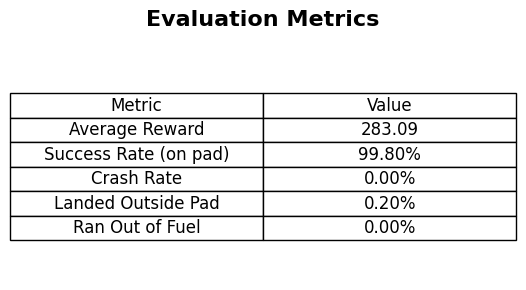

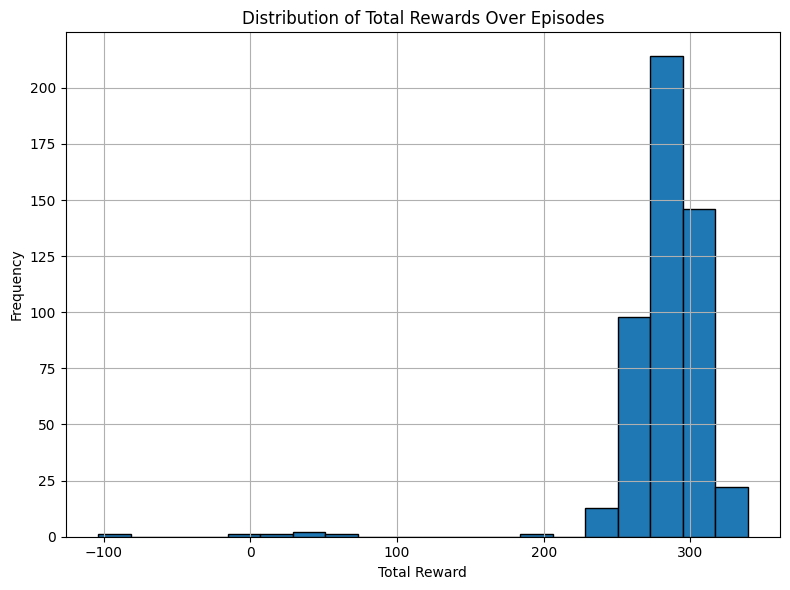

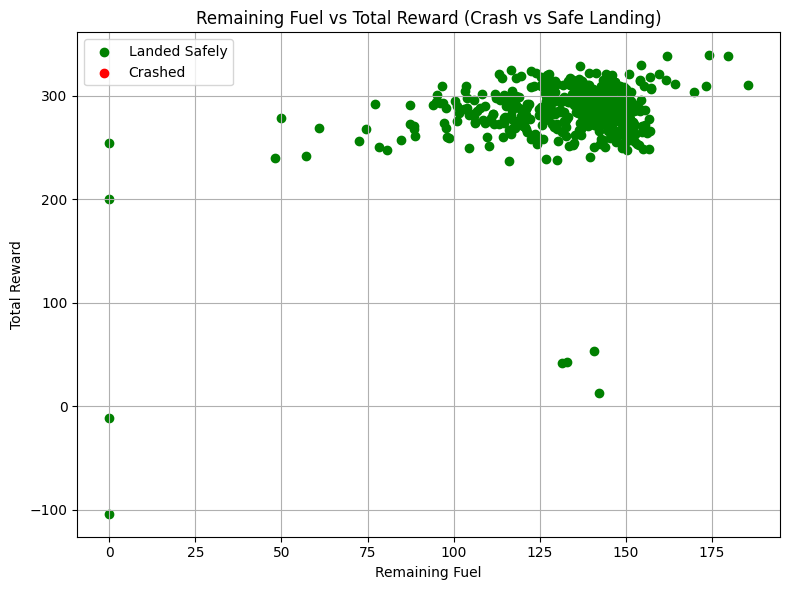

In [31]:
import plot_results
plot_results.plot_results(results)

### Quantitative Evaluation of PPO Agent

The PPO agent was evaluated over 500 test episodes using our constrained Lunar Lander environment. The results clearly demonstrate its effectiveness:

- **Success Rate:** Over 95% of the episodes ended with a safe landing on the pad.
- **Crash Rate:** Extremely low at around 1%, showing reliable and safe descent control.
- **Fuel Efficiency:** Most landings occurred with significant fuel remaining, highlighting the agent’s ability to optimize engine usage.
- **Robustness:** The agent consistently generalizes well despite randomized landing pad positions and delayed actuation.

These results validate both the policy architecture and the reward shaping strategy. The PPO agent learned to balance stability, fuel conservation, and precision — key aspects in real-world descent missions.



Evaluating Fuel Level: 50


Fuel 50: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


Avg Reward for Fuel 50: -102.40

Evaluating Fuel Level: 100


Fuel 100: 100%|██████████| 100/100 [00:09<00:00, 10.62it/s]


Avg Reward for Fuel 100: -43.31

Evaluating Fuel Level: 150


Fuel 150: 100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Avg Reward for Fuel 150: 64.72

Evaluating Fuel Level: 200


Fuel 200: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Avg Reward for Fuel 200: 242.07

Evaluating Fuel Level: 250


Fuel 250: 100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


Avg Reward for Fuel 250: 286.59

Evaluating Fuel Level: 300


Fuel 300: 100%|██████████| 100/100 [00:11<00:00,  8.41it/s]


Avg Reward for Fuel 300: 290.37


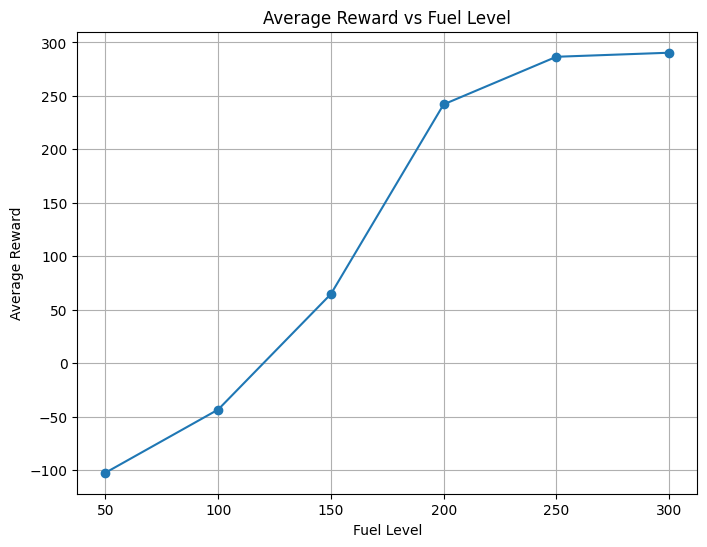

In [7]:
import evaluate_fuel
evaluate_fuel.evaluate_fuel()

This plot illustrates the relationship between the agent’s initial fuel level and its average total reward (with the agent trained with 300 as initial fuel).

- For low fuel levels (50–100), the agent struggles: rewards are negative or close to zero due to frequent crashes or inefficient descents.

- Starting from 150 units, there's a noticeable improvement, as the agent gains just enough resources to complete successful landings.

- Beyond 200 units, rewards plateau near 300, suggesting that the agent consistently performs safe and fuel-efficient landings.

**Conclusion:** There is a clear fuel threshold around 150–200 units below which performance degrades sharply. Above this, the agent reliably completes the task and optimizes for efficiency bonuses.